## Imports

In [1]:
from bs4 import BeautifulSoup
from fuzzywuzzy import process
import requests
# import matplotlib.pyplot as plt
import altair as alt
from collections import OrderedDict
import pandas as pd

from selenium.webdriver import Chrome, ChromeOptions
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

# Scraping w/ Selenium 

In [2]:
zack_url = "https://scholar.google.com/citations?user=X7FY3wUAAAAJ&hl=en&oi=ao"
hinton_url = "https://scholar.google.com/citations?user=JicYPdAAAAAJ&hl=en&oi=ao"
malcolm_url = "https://scholar.google.de/citations?user=bcO-7KwAAAAJ&hl=en&oi=ao"

In [3]:
options = ChromeOptions()
options.headless = True
driver = Chrome(options=options)

In [4]:
button_xpath = "/html/body/div/div[13]/div[2]/div/div[4]/form/div[2]/div/button"

In [5]:
# driver.get(hinton_url)
driver.get(malcolm_url)
count = 0

while True:  
    try:
        button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, button_xpath)))
        button.click()
        count += 1
        print(f"click number: {count}")
        
    except TimeoutException:
        print('not clickable')
        break

html = driver.page_source

not clickable


In [6]:
driver.close()

# Get data w/ BeautifulSoup

In [7]:
page = BeautifulSoup(html)

### Get author name

In [8]:
page_title = page.find('title').string
author_name = page_title.split(' - ')[0]
author_name

'Malcolm S.W. Hodgskiss'

### Get current role

In [9]:
temp = []
for x in page.find_all("div", attrs={"class": "gsc_prf_il"}):
    temp.append(x.text)
    
temp[0]

'Ph.D Candidate | Stanford University'

### Get citation counts for each paper

In [10]:
# get citations for each paper 
citations_lis = []
for td in page.find_all("td", attrs={"class": "gsc_a_c"}):
    citation = td.find("a").contents
    citations_lis.append(citation)

print(citations_lis[:3])
print(len(citations_lis))

[['134'], ['60'], ['19']]
14


In [11]:
citations_lis = [int(c[0]) if len(c)==1 else 0 for c in citations_lis]
len(citations_lis)

14

In [12]:
sum(citations_lis)

286

Weird that this different from Google's listed total citations for Geoffrey Hinton: 372718.

Seems they might be taking into account duplicate publications when counting total citations, but not when calculating the author's overall h-index, as you'll see later in the notebook.

### Get publication dates

In [13]:
# get years for each paper 
years_lis = []
for yr in page.find_all("span", attrs={"class": "gs_oph"}):
    years_lis.append(yr.text)

# remove the extras
# years_lis = [text for i,text in enumerate(years_lis) if i%2==0]
years_lis[:5]

[', 2016', ', 2018', ', 2018', ', 2017', ', 2017']

In [14]:
len(years_lis)

14

There are missing values from the years list because sometimes that section is blank on the website, but the year is listed in the title of the paper section instead.

Also, it seems there are duplicate publications listed on some Google Scholar profiles. For example on Geoffrey Hinton's, "Layer Normalization" is listed three different times. Same authors, same journal (arXiv), but different citations counts.

Google is not taking this into account in there h-index calculations b/c I reproduced theirs by including duplicates.

In [15]:
# TODO: 

# would need to extract the dates from the publication title where date is missing from usual spot,
# and account for bogus years like "6" for "Williams, RI (1986). Learning internal representations by error propagation"
# and sometimes there's no date listed at all in the title either

# also just need to clean up the year strings (ex: ', 1986' --> 1986)

### Get co-authors for each publication

In [16]:
# get authors of each paper
authors_journals = []
for auth in page.find_all("div", attrs={"class": "gs_gray"}):
    authors_journals.append(auth.text)
    
# remove extra gs_gray classes found (the journal names)
authors = [text for i,text in enumerate(authors_journals) if i%2==0]

# clean up and split names
author_lists = [names.split(', ') for names in authors]

print(len(author_lists))

14


In [17]:
author_lists[:3]

[['DB Cole',
  'CT Reinhard',
  'X Wang',
  'B Gueguen',
  'GP Halverson',
  'T Gibson',
  '...'],
 ['TM Gibson', 'PM Shih', 'VM Cumming', 'WW Fischer', 'PW Crockford', '...'],
 ['PW Crockford',
  'MSW Hodgskiss',
  'GJ Uhlein',
  'F Caxito',
  'JA Hayles',
  '...']]

# Format data by year(to-do), co-author pos, & h-index

### Get co-author positions

In [18]:
# scary one-liner to convert int to ordinal representation (ex: 2 --> "2nd")
# https://stackoverflow.com/questions/9647202/ordinal-numbers-replacement
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

In [19]:
def get_author_positions_lis(auth_name, auth_lists):
    ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])
    author_positions_lis = []

    for names in auth_lists:
#         print(names)
        try: 
            match = process.extractOne(auth_name, names, score_cutoff=80)[0]
#             print(match)
        except TypeError: 
            match = None
#             print('no match')
            
        if match:
            for i, author in enumerate(names):
                if author == match:

                    if i == len(names)-1 and i > 2:
                        author_positions_lis.append('last')
                    elif i > 4:
                        author_positions_lis.append('6th or more')
                    else:
                        author_positions_lis.append(ordinal(i+1))
                    break
        else:
            if len(names) > 4:
                author_positions_lis.append('6th or more')
            else:
                author_positions_lis.append(ordinal(len(names)))
            
    return author_positions_lis

author_positions_lis = get_author_positions_lis(author_name, author_lists)

print(author_positions_lis[:5])
print(len(author_positions_lis))

['6th or more', '6th or more', '2nd', '4th', '4th']
14


In [20]:
set(author_positions_lis)

{'1st', '2nd', '4th', '6th or more'}

### Group citations by co-author position

In [40]:
def get_pos_dfs(pos_lis, num_lis):
    citations_positions_df = pd.DataFrame(list(zip(pos_lis, num_lis)), columns =['positions', 'citations']) 
    return dict(tuple(citations_positions_df.groupby('positions')))


dfs = get_pos_dfs(author_positions_lis, citations_lis)
dfs.keys()

dict_keys(['1st', '2nd', '4th', '6th or more'])

In [41]:
dfs['1st'].head()

,positions,citations
6,1st,7
7,1st,6
9,1st,4
12,1st,0
13,1st,0


### Get h-indexes by co-author position

In [42]:
def get_hindexes_dict(dataframes):
    hindexes_dict = {}
    
    for k, df in dataframes.items():
        df.sort_values('citations')
        df.index += 1
        df = df.reset_index()
        df = df.query('citations >= index')
        # checking if there are no citations
        if df.shape[0] <= 0:
            hindexes_dict[k] = 0
        else:
            hindexes_dict[k] = df.shape[0]
        
    return hindexes_dict
        
hindexes_d = get_hindexes_dict(dfs)

In [43]:
# excluding co-author position w/ h-index of zero
hindexes_d

{'1st': 1, '2nd': 1, '4th': 3, '6th or more': 2}

In [44]:
sum(hindexes_d.values()) - 1

6

In [45]:
# Regular h-index (same as Google's)
temp_df = pd.DataFrame({"citations": citations_lis})
temp_df.sort_values('citations')
temp_df.index += 1
temp_df = temp_df.reset_index()
temp_df = temp_df.query('citations >= index')
temp_df.shape[0] - 1

6

In [46]:
pd.DataFrame({'position': list(hindexes_d.keys()), 'h-index': list(hindexes_d.values())}).set_index('position')

,h-index
position,
1st,1
2nd,1
4th,3
6th or more,2


# Format data for plotting

In [47]:
def get_counts_dicts(pos_lis, num_lis):
    d1 = {}
    d2 = {}

    for position, num in zip(pos_lis, num_lis):
        if position in d1:
            d1[position] += 1
            d2[position] += num
        else:
            d1[position] = 1
            d2[position] = num
    return d1, d2
        
author_positions, citations_by_author_position = get_counts_dicts(author_positions_lis, citations_lis)

print(f'author_positions: {author_positions}')
print(f'citations_by_author_position: {citations_by_author_position}')

author_positions: {'6th or more': 3, '2nd': 1, '4th': 5, '1st': 5}
citations_by_author_position: {'6th or more': 197, '2nd': 19, '4th': 53, '1st': 17}


In [48]:
author_positions = OrderedDict(sorted(author_positions.items()))
citations = OrderedDict(sorted(citations_by_author_position.items()))

In [49]:
print(author_positions)
print(citations)

OrderedDict([('1st', 5), ('2nd', 1), ('4th', 5), ('6th or more', 3)])
OrderedDict([('1st', 17), ('2nd', 19), ('4th', 53), ('6th or more', 197)])


In [50]:
lis1 = list(citations.keys())
lis2 = list(citations.values())

In [51]:
df = pd.DataFrame({
                "positions": lis1,
                "citations": lis2
            })
percents_df = df.copy()
percents_df.citations = (100 * df.citations / df.citations.sum()).round(0)
percents_df.citations = percents_df.citations / 100
# percents_df = percents_df.fillna(0)
percents_df

,positions,citations
0,1st,0.06
1,2nd,0.07
2,4th,0.19
3,6th or more,0.69


# Plot w/ Altair

In [52]:
def bar_chart(df):
    return alt.Chart(df).mark_bar().encode(
        alt.X('citations', axis=alt.Axis(format='%')),
        y='positions',
        color=alt.Color(
            "positions", 
            scale=alt.Scale(scheme="greenblue"), 
            legend=None
            )
        ).properties(
            title='portion of total citations by co-author position'
        ).configure_axisX(
            labelAngle=0
        ).configure_view(
            strokeWidth=0
        )


bar_chart(percents_df).display()

alt.Chart(...)

# Plot w/ Matplotlib

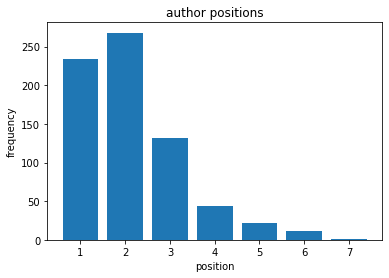

In [89]:
plt.bar(list(author_positions.keys()), list(author_positions.values()))
plt.title("author positions")
plt.xlabel("position")
plt.ylabel("frequency");

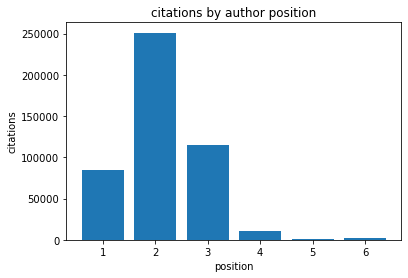

In [19]:
plt.bar(list(citations_by_author_position.keys()), list(citations_by_author_position.values()))
plt.title("citations by author position")
plt.xlabel("position")
plt.ylabel("citations");